In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
[V1]
* Resolution: Resized to 512x512 from 768x768
* Extract cell masks and create individual cell images (512x512)
* No random crop
* No TTA
* Update normalization mean and std with 2021 training and test sets

Note: HPA-Cell-Segmentatior assume that all input images are of the same shape!
"""

kernel_mode = False

import sys
if kernel_mode:
    sys.path.insert(0, "../input/pytorch-lightning")
    sys.path.insert(0, "../input/hpa-bestfitting")
    sys.path.insert(0, "../input/hpa-cell-segmentation")

import sys
import argparse
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import time
import random
import math
import pickle
from pickle import dump, load
import glob
import time
import collections

import torch
import torch.optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.nn import DataParallel
import torch.nn.functional as F
from torch.autograd import Variable

from config.config import *
from utils.common_util import *
from networks.imageclsnet import init_network
from datasets.protein_dataset import ProteinDataset
from utils.augment_util import *
from datasets.tool import *

import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.metrics.functional import classification

from pycocotools import _mask as coco_mask
import typing as t
import base64
import zlib

import cv2
from PIL import Image
import imagehash

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import gc
gc.enable()

rand_seed = 1120

print(f"PyTorch Version: {torch.__version__}")
print(f"PyTorch Lightning Version: {pl.__version__}")

run on 2fb1688be1a5
PyTorch Version: 1.6.0+cu101
PyTorch Lightning Version: 1.1.1


In [3]:
debug = True

dataset_folder = "/workspace/Kaggle/HPA/hpa_2020"
bestfitting_folder = "/workspace/Github/HPA-competition-solutions/bestfitting"
test_image_folder = f"{dataset_folder}/test/"
NUC_MODEL = "/workspace/Github/HPA-Cell-Segmentation/dpn_unet_nuclei_v1.pth"
CELL_MODEL = "/workspace/Github/HPA-Cell-Segmentation/dpn_unet_cell_3ch_v1.pth"

# image_size = 2048
image_size = 768
crop_size = 512

batch_size = 6
# batch_size = 4
num_workers = 3

# confidence_threshold = 0.0
confidence_threshold = 0.5

In [4]:
old_classes = {
    0: 'Nucleoplasm',
    1: 'Nuclear membrane',
    2: 'Nucleoli',
    3: 'Nucleoli fibrillar center',
    4: 'Nuclear speckles',
    5: 'Nuclear bodies',
    6: 'Endoplasmic reticulum',
    7: 'Golgi apparatus',
    8: 'Peroxisomes',
    9: 'Endosomes',
    10: 'Lysosomes',
    11: 'Intermediate filaments',
    12: 'Actin filaments',
    13: 'Focal adhesion sites',
    14: 'Microtubules',
    15: 'Microtubule ends',
    16: 'Cytokinetic bridge',
    17: 'Mitotic spindle',
    18: 'Microtubule organizing center',
    19: 'Centrosome',
    20: 'Lipid droplets',
    21: 'Plasma membrane',
    22: 'Cell junctions',
    23: 'Mitochondria',
    24: 'Aggresome',
    25: 'Cytosol',
    26: 'Cytoplasmic bodies',
    27: 'Rods & rings'
}
old_class_indices = {v: k for k, v in old_classes.items()}

# All label names in the public HPA and their corresponding index.
all_locations = dict({
    "Nucleoplasm": 0,
    "Nuclear membrane": 1,
    "Nucleoli": 2,
    "Nucleoli fibrillar center": 3,
    "Nuclear speckles": 4,
    "Nuclear bodies": 5,
    "Endoplasmic reticulum": 6,
    "Golgi apparatus": 7,
    "Intermediate filaments": 8,
    "Actin filaments": 9,
    "Focal adhesion sites": 9,
    "Microtubules": 10,
    "Mitotic spindle": 11,
    "Centrosome": 12,
    "Centriolar satellite": 12,
    "Plasma membrane": 13,
    "Cell Junctions": 13,
    "Mitochondria": 14,
    "Aggresome": 15,
    "Cytosol": 16,
    "Vesicles": 17,
    "Peroxisomes": 17,
    "Endosomes": 17,
    "Lysosomes": 17,
    "Lipid droplets": 17,
    "Cytoplasmic bodies": 17,
    "Rods & rings": 18,
    # markpeng
    "No staining": 18,
})

old_class_mappings = {}
for i, (k, v) in enumerate(old_class_indices.items()):
    if k in all_locations:
        old_class_mappings[v] = all_locations[k]
    else:
        # No staining
        old_class_mappings[v] = 18
assert len(old_class_mappings.values()) == len(old_classes.values())
print(old_class_mappings)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 17, 9: 17, 10: 17, 11: 8, 12: 9, 13: 9, 14: 10, 15: 18, 16: 18, 17: 11, 18: 18, 19: 12, 20: 17, 21: 13, 22: 18, 23: 14, 24: 15, 25: 16, 26: 17, 27: 18}


In [5]:
# {
#     'Nucleoplasm': 0,
#     'Nuclear membrane': 1,
#     'Nucleoli': 2,
#     'Nucleoli fibrillar center': 3,
#     'Nuclear speckles': 4,
#     'Nuclear bodies': 5,
#     'Endoplasmic reticulum': 6,
#     'Golgi apparatus': 7,
#     'Peroxisomes': 17,
#     'Endosomes': 17,
#     'Lysosomes': 17,
#     'Intermediate filaments': 8,
#     'Actin filaments': 9,
#     'Focal adhesion sites': 9,
#     'Microtubules': 10,
#     'Microtubule ends': 18,
#     'Cytokinetic bridge': 18,
#     'Mitotic spindle': 11,
#     'Microtubule organizing center': 18,
#     'Centrosome': 12,
#     'Lipid droplets': 17,
#     'Plasma membrane': 13,
#     'Cell junctions': 18,
#     'Mitochondria': 14,
#     'Aggresome': 15,
#     'Cytosol': 16,
#     'Cytoplasmic bodies': 17,
#     'Rods & rings': 18
# }

In [6]:
!ls {dataset_folder}

inference	       test	       train	  train_tfrecords
sample_submission.csv  test_tfrecords  train.csv


In [7]:
train_df = pd.read_csv(f"{dataset_folder}/train.csv")
submit_df = pd.read_csv(f"{dataset_folder}/sample_submission.csv")

In [8]:
print(train_df.shape)
train_df.head()

(21806, 2)


,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [9]:
print(submit_df.shape, submit_df.ImageWidth.min(), submit_df.ImageWidth.max())
submit_df.head()

(559, 4) 1728 3072


,ID,ImageWidth,ImageHeight,PredictionString
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
1,004a270d-34a2-4d60-bbe4-365fca868193,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
2,00537262-883c-4b37-a3a1-a4931b6faea5,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
3,00c9a1c9-2f06-476f-8b0d-6d01032874a2,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
4,0173029a-161d-40ef-af28-2342915b22fb,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==


In [10]:
colors = ["red", "green", "blue", "yellow"]

# Extract unique image IDs
# test_ids = [
#     f.split("/")[-1].replace("_red.png", "")
#     for f in glob.glob(f"{test_image_folder}/*_red.png")
# ]
# print(len(test_ids))
test_ids = submit_df["ID"].values.tolist()
print(len(test_ids))

# Estimated number of private test images (RGBY): 2236 x 2.3 ~= 5143 (for 9 hours we have 6.2 secs per image)
# Estimated number of private test images: 559 x 2.3 ~= 1286 (for 9 hours we have 25.2 secs per image)

559


## Utility Functions

In [11]:
# Reference: https://www.kaggle.com/dschettler8845/hpa-cellwise-classification-inference/notebook
def binary_mask_to_ascii(mask, mask_val=1):
    """Converts a binary mask into OID challenge encoding ascii text."""
    mask = np.where(mask == mask_val, 1, 0).astype(np.bool)

    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError(
            f"encode_binary_mask expects a binary mask, received dtype == {mask.dtype}"
        )

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            f"encode_binary_mask expects a 2d mask, received shape == {mask.shape}"
        )

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str.decode()


def rle_encoding(img, mask_val=1):
    """
    Turns our masks into RLE encoding to easily store them
    and feed them into models later on
    https://en.wikipedia.org/wiki/Run-length_encoding
    
    Args:
        img (np.array): Segmentation array
        mask_val (int): Which value to use to create the RLE
        
    Returns:
        RLE string
    
    """
    dots = np.where(img.T.flatten() == mask_val)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b

    return ' '.join([str(x) for x in run_lengths])


def rle_to_mask(rle_string, height, width):
    """ Convert RLE sttring into a binary mask 
    
    Args:
        rle_string (rle_string): Run length encoding containing 
            segmentation mask information
        height (int): Height of the original image the map comes from
        width (int): Width of the original image the map comes from
    
    Returns:
        Numpy array of the binary segmentation mask for a given cell
    """
    rows, cols = height, width
    rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
    rle_pairs = np.array(rle_numbers).reshape(-1, 2)
    img = np.zeros(rows * cols, dtype=np.uint8)
    for index, length in rle_pairs:
        index -= 1
        img[index:index + length] = 255
    img = img.reshape(cols, rows)
    img = img.T
    return img


def create_segmentation_maps(list_of_image_lists, segmentator, batch_size=8):
    """ Function to generate segmentation maps using CellSegmentator tool 
    
    Args:
        list_of_image_lists (list of lists):
            - [[micro-tubules(red)], [endoplasmic-reticulum(yellow)], [nucleus(blue)]]
        batch_size (int): Batch size to use in generating the segmentation masks
        
    Returns:
        List of lists containing RLEs for all the cells in all images
    """

    all_mask_rles = {}
    for i in tqdm(range(0, len(list_of_image_lists[0]), batch_size),
                  total=len(list_of_image_lists[0]) // batch_size):

        # Get batch of images
        sub_images = [
            img_channel_list[i:i + batch_size]
            for img_channel_list in list_of_image_lists
        ]  # 0.000001 seconds

        # Do segmentation
        cell_segmentations = segmentator.pred_cells(sub_images)
        nuc_segmentations = segmentator.pred_nuclei(sub_images[2])

        # post-processing
        for j, path in enumerate(sub_images[0]):
            img_id = path.replace("_red.png", "").rsplit("/", 1)[1]
            nuc_mask, cell_mask = label_cell(nuc_segmentations[j],
                                             cell_segmentations[j])
            new_name = os.path.basename(path).replace('red', 'mask')
            all_mask_rles[img_id] = [
                rle_encoding(cell_mask, mask_val=k)
                for k in range(1,
                               np.max(cell_mask) + 1)
            ]
    return all_mask_rles


def get_img_list(img_dir, return_ids=False, sub_n=None):
    """ Get image list in the format expected by the CellSegmentator tool """
    if sub_n is None:
        sub_n = len(glob(img_dir + '/' + f'*_red.png'))
    if return_ids:
        images = [
            sorted(glob(img_dir + '/' + f'*_{c}.png'))[:sub_n]
            for c in ["red", "yellow", "blue"]
        ]
        return [
            x.replace("_red.png", "").rsplit("/", 1)[1] for x in images[0]
        ], images
    else:
        return [
            sorted(glob(img_dir + '/' + f'*_{c}.png'))[:sub_n]
            for c in ["red", "yellow", "blue"]
        ]


def get_contour_bbox_from_rle(
    rle,
    width,
    height,
    return_mask=True,
):
    """ Get bbox of contour as `xmin ymin xmax ymax`
    
    Args:
        rle (rle_string): Run length encoding containing 
            segmentation mask information
        height (int): Height of the original image the map comes from
        width (int): Width of the original image the map comes from
    
    Returns:
        Numpy array for a cell bounding box coordinates
    """
    mask = rle_to_mask(rle, height, width).copy()
    cnts = grab_contours(
        cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE))
    x, y, w, h = cv2.boundingRect(cnts[0])

    if return_mask:
        return (x, y, x + w, y + h), mask
    else:
        return (x, y, x + w, y + h)


def get_contour_bbox_from_raw(raw_mask):
    """ Get bbox of contour as `xmin ymin xmax ymax`
    
    Args:
        raw_mask (nparray): Numpy array containing segmentation mask information
    
    Returns:
        Numpy array for a cell bounding box coordinates
    """
    cnts = grab_contours(
        cv2.findContours(raw_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE))
    xywhs = [cv2.boundingRect(cnt) for cnt in cnts]
    xys = [(xywh[0], xywh[1], xywh[0] + xywh[2], xywh[1] + xywh[3])
           for xywh in xywhs]
    return sorted(xys, key=lambda x: (x[1], x[0]))


def pad_to_square(a):
    """ Pad an array `a` evenly until it is a square """
    if a.shape[1] > a.shape[0]:  # pad height
        n_to_add = a.shape[1] - a.shape[0]
        top_pad = n_to_add // 2
        bottom_pad = n_to_add - top_pad
        a = np.pad(a, [(top_pad, bottom_pad), (0, 0), (0, 0)], mode='constant')

    elif a.shape[0] > a.shape[1]:  # pad width
        n_to_add = a.shape[0] - a.shape[1]
        left_pad = n_to_add // 2
        right_pad = n_to_add - left_pad
        a = np.pad(a, [(0, 0), (left_pad, right_pad), (0, 0)], mode='constant')
    else:
        pass
    return a


def cut_out_cells(rgby,
                  rles,
                  resize_to=(256, 256),
                  square_off=True,
                  return_masks=False,
                  from_raw=True):
    """ Cut out the cells as padded square images 
    
    Args:
        rgby (np.array): 4 Channel image to be cut into tiles
        rles (list of RLE strings): List of run length encoding containing 
            segmentation mask information
        resize_to (tuple of ints, optional): The square dimension to resize the image to
        square_off (bool, optional): Whether to pad the image to a square or not
        
    Returns:
        list of square arrays representing squared off cell images
    """
    w, h = rgby.shape[:2]
    contour_bboxes = [
        get_contour_bbox(rle, w, h, return_mask=return_masks) for rle in rles
    ]
    if return_masks:
        masks = [x[-1] for x in contour_bboxes]
        contour_bboxes = [x[:-1] for x in contour_bboxes]

    arrs = [
        rgby[bbox[1]:bbox[3], bbox[0]:bbox[2], ...] for bbox in contour_bboxes
    ]
    if square_off:
        arrs = [pad_to_square(arr) for arr in arrs]

    if resize_to is not None:
        arrs = [
            cv2.resize(pad_to_square(arr).astype(np.float32),
                       resize_to,
                       interpolation=cv2.INTER_CUBIC) \
            for arr in arrs
        ]
    if return_masks:
        return arrs, masks
    else:
        return arrs


def grab_contours(cnts):
    # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]

    # if the length of the contours tuple is '3' then we are using
    # either OpenCV v3, v4-pre, or v4-alpha
    elif len(cnts) == 3:
        cnts = cnts[1]

    # otherwise OpenCV has changed their cv2.findContours return
    # signature yet again and I have no idea WTH is going on
    else:
        raise Exception(
            ("Contours tuple must have length 2 or 3, "
             "otherwise OpenCV changed their cv2.findContours return "
             "signature yet again. Refer to OpenCV's documentation "
             "in that case"))

    # return the actual contours array
    return cnts

In [12]:
# https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/72534
def generate_hash(img_dir,
                  colors,
                  dataset='train',
                  imread_func=None,
                  is_update=False):
    meta = meta.copy()
    hash_maps = {}
    for color in colors:
        hash_maps[color] = []
        for idx in tqdm(range(len(meta)), desc='train %s' % color):
            img = imread_func(img_dir, meta.iloc[idx][ID], color)
            hash = imagehash.phash(img)
            hash_maps[color].append(hash)

    for color in colors:
        meta[color] = hash_maps[color]

    return meta


def calc_hash(params):
    color, threshold, base_test_hash1, base_test_hash2, test_ids1, test_ids2 = params

    test_hash1 = base_test_hash1.reshape(1, -1)  # 1*m

    test_idxes_list1 = []
    test_idxes_list2 = []
    hash_list = []

    step = 5
    for test_idx in tqdm(range(0, len(base_test_hash2), step), desc=color):
        test_hash2 = base_test_hash2[test_idx:test_idx + step].reshape(
            -1, 1)  # n*1
        hash = test_hash2 - test_hash1  # n*m
        test_idxes2, test_idxes1 = np.where(hash <= threshold)
        hash = hash[test_idxes2, test_idxes1]

        test_idxes2 = test_idxes2 + test_idx

        test_idxes_list1.extend(test_idxes1.tolist())
        test_idxes_list2.extend(test_idxes2.tolist())
        hash_list.extend(hash.tolist())

    df = pd.DataFrame({
        'Test1': test_ids1[test_idxes_list1],
        'Test2': test_ids2[test_idxes_list2],
        'Sim%s' % color[:1].upper(): hash_list
    })
    df = df[df['Test1'] != df['Test2']]
    return df

## Preprocessing

### Calculate Mean and Std From Training and Test Sets

In [13]:
# !python {bestfitting_folder}/src/data_process/s8_generate_images_mean_std.py \
#     --source /workspace/Kaggle/HPA/hpa_2020

In [14]:
total_mean = [0.081018, 0.052349, 0.054012, 0.08106] # rgby
total_std = [0.133235, 0.08948, 0.143813, 0.130265]

### Resize and Save All Images

In [15]:
# !python {bestfitting_folder}/src/data_process/s2_resize_png_image.py \
#     --source {dataset_folder} \
#     --dest {dataset_folder} \
#     --dataset test \
#     --size {image_size}

In [16]:
# def convert_image(image_folder, image_id, size):
#     print(f"Convering image {image_id}")
#     rgby = []
#     for c in colors:
#         image = np.array(Image.open(
#             os.path.join(image_folder, image_id + f"_{c}.png")),
#                          dtype=np.float32)

#         # Resize
#         image = cv2.resize(image, (size, size), interpolation=cv2.INTER_LINEAR)
#         rgby.append(image)

#     return np.stack(rgby, axis=0)

In [17]:
# start_time = time.time()
# test_images = [convert_image(test_image_folder, id, image_size) for id in test_ids]
# print(f"Time spent on loading test images: {(time.time() - start_time)/60:.2f} minutes")

In [18]:
# gc.collect()
# print(f"Resized test images: {sys.getsizeof(test_images)/1024:.2f} MB")

### Find Similar Images (TODO)

In [19]:
# similarity_threshold = 12

In [20]:
# colors = ['red', 'green', 'blue']
# test_meta = generate_hash(test_img_dir,
#                           test_meta,
#                           colors,
#                           dataset='test',
#                           imread_func=test_imread,
#                           is_update=False)

## Dataset

In [21]:
# Based on https://github.com/CellProfiling/HPA-competition-solutions/tree/master/bestfitting
class ProteinDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        img_dir=None,
        img_size=512,
        transform=None,
        return_label=True,
        in_channels=4,
        crop_size=0,
        random_crop=False,
    ):
        self.img_size = img_size
        self.return_label = return_label
        self.in_channels = in_channels
        self.transform = transform
        self.crop_size = crop_size
        self.random_crop = random_crop

        self.img_dir = img_dir

        self.img_ids = test_ids
        self.num = len(self.img_ids)

    def read_crop_img(self, img):
        random_crop_size = int(np.random.uniform(self.crop_size,
                                                 self.img_size))
        x = int(np.random.uniform(0, self.img_size - random_crop_size))
        y = int(np.random.uniform(0, self.img_size - random_crop_size))
        crop_img = img[x:x + random_crop_size, y:y + random_crop_size]
        return crop_img

    def read_rgby(self, img_dir, img_id, index):
        suffix = '.png'
        colors = ['red', 'green', 'blue', 'yellow']

        flags = cv2.IMREAD_GRAYSCALE
        img = [
            cv2.imread(opj(img_dir, img_id + '_' + color + suffix), flags)
            for color in colors
        ]
        img = np.stack(img, axis=-1)
        if self.random_crop and self.crop_size > 0:
            img = self.read_crop_img(img)
        return img

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        image = self.read_rgby(self.img_dir, img_id, index)
        if image[0] is None:
            print(img_dir, img_id)

        h, w = image.shape[:2]
        self.img_size = h

        if self.crop_size > 0:
            if self.crop_size != h or self.crop_size != w:
                image = cv2.resize(image, (self.crop_size, self.crop_size),
                                   interpolation=cv2.INTER_LINEAR)
        else:
            if self.img_size != h or self.img_size != w:
                image = cv2.resize(image, (self.img_size, self.img_size),
                                   interpolation=cv2.INTER_LINEAR)

        if self.transform is not None:
            image = self.transform(image)
        image = image / 255.0
        image = image_to_tensor(image)

        if self.return_label:
            label = self.labels[index]
            return image, label, index
        else:
            return image, index

    def __len__(self):
        return self.num

In [22]:
tmp_dataset = ProteinDataset(
    img_dir="/workspace/Kaggle/HPA/hpa_2020/inference/test/images_768",
    img_size=768,
    return_label=False,
    in_channels=4,
    transform=None,
    crop_size=512,
    random_crop=True,
)
tmpiter = iter(tmp_dataset)
tmp_img, tmp_index = next(tmpiter)
print(tmp_img.shape, tmp_index)

torch.Size([4, 512, 512]) 0


In [35]:
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei


# Based on https://github.com/CellProfiling/HPA-competition-solutions/tree/master/bestfitting
class SegmentedProteinDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        img_dir=None,
        transform=None,
        return_label=True,
        in_channels=4,
        crop_size=0,
        random_crop=False,
    ):
        self.return_label = return_label
        self.in_channels = in_channels
        self.transform = transform
        self.crop_size = crop_size
        self.random_crop = random_crop

        self.segmentator = cellsegmentator.CellSegmentator(
            NUC_MODEL,
            CELL_MODEL,
            scale_factor=0.25,
            device="cuda",
            padding=True,
            multi_channel_model=True,
        )

        self.img_dir = img_dir
        self.img_ids = test_ids
        self.num = len(self.img_ids)

    def read_crop_img(self, img):
        random_crop_size = int(np.random.uniform(self.crop_size,
                                                 self.img_size))
        x = int(np.random.uniform(0, self.img_size - random_crop_size))
        y = int(np.random.uniform(0, self.img_size - random_crop_size))
        crop_img = img[x:x + random_crop_size, y:y + random_crop_size]
        return crop_img

    def read_rgby(self, img_dir, img_id, index):
        suffix = '.png'
        colors = ['red', 'green', 'blue', 'yellow']

        flags = cv2.IMREAD_GRAYSCALE
        rgby_img = [
            cv2.imread(opj(img_dir, img_id + '_' + color + suffix), flags)
            for color in colors
        ]
        for color in colors:
            print(opj(img_dir, img_id + '_' + color + suffix))
        rgby_img = np.stack(rgby_img, axis=-1)
        if self.random_crop and self.crop_size > 0:
            rgby_img = self.read_crop_img(rgby_img)

        return rgby_img

    def release_gpu(self):
        # Not work
        del self.segmentator
        torch.cuda.empty_cache()
        gc.collect()

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        #         img_id = "0173029a-161d-40ef-af28-2342915b22fb"

        rgby_img = self.read_rgby(self.img_dir, img_id, index)
        if rgby_img[0] is None:
            print(self.img_dir, img_id)

        # print(rgby_img.shape)

        h, w = rgby_img.shape[:2]
        self.img_size = h

        if self.crop_size > 0:
            if self.crop_size != h or self.crop_size != w:
                resized_rgby_img = cv2.resize(rgby_img,
                                              (self.crop_size, self.crop_size),
                                              interpolation=cv2.INTER_LINEAR)
        else:
            if self.img_size != h or self.img_size != w:
                resized_rgby_img = cv2.resize(rgby_img,
                                              (self.img_size, self.img_size),
                                              interpolation=cv2.INTER_LINEAR)

        if self.transform is not None:
            resized_rgby_img = self.transform(resized_rgby_img)
        # rgby_img = rgby_img / 255.0

        # For nuclei
        nuc_segmentations = self.segmentator.pred_nuclei([rgby_img[:, :, 2]])

        # For full cells
        cell_segmentations = self.segmentator.pred_cells([[rgby_img[:, :, i]]
                                                          for i in [0, 3, 2]])

        # Extract cell masks
        _, full_mask = label_cell(nuc_segmentations[0], cell_segmentations[0])

        print(full_mask.shape)
        full_mask = cv2.resize(full_mask, (self.crop_size, self.crop_size),
                               interpolation=cv2.INTER_NEAREST)

        # print(np.min(full_mask), np.max(full_mask))
        cell_masks = [
            rle_encoding(full_mask, mask_val=k)
            for k in range(1,
                           np.max(full_mask) + 1)
        ]
        #         cell_masks = [
        #             rle_encoding(full_mask, mask_val=k)
        #             for k in range(1,
        #                            np.max(full_mask) + 1)
        #         ]
        if len(cell_masks) == 0:
            print(f"No cell masks found for {img_id}")

        fig, ax = plt.subplots(figsize=(10, 10))
        #         gbr_img = np.dstack([rgby_img[..., :i] for i in range(3)])
        gbr_img = np.dstack([resized_rgby_img[..., :i] for i in [2, 1, 0]])
        #         print(gbr_img.shape)
        ax.imshow(gbr_img)
        ax.imshow(full_mask, alpha=0.5)
        plt.show()

        #         print(resized_rgby_img.shape)

        resized_rgby_img = resized_rgby_img / 255.0
        resized_rgby_img = image_to_tensor(resized_rgby_img)

        if self.return_label:
            label = self.labels[index]
            return resized_rgby_img, cell_masks, label, img_id
        else:
            return resized_rgby_img, cell_masks, img_id


#         if self.return_label:
#             label = self.labels[index]
#             return rgby_img, cell_masks, label, img_id
#         else:
#             return rgby_img, cell_masks, img_id

    def __len__(self):
        return self.num

In [36]:
# tmp_dataset = SegmentedProteinDataset(
#     img_dir="/workspace/Kaggle/HPA/hpa_2020/test",
#     #     img_dir="/workspace/Kaggle/HPA/hpa_2020/inference/test/images_768",
#     img_size=None,
#     #     img_size=768,
#     return_label=False,
#     in_channels=4,
#     transform=None,
#     # crop_size=3072,
#     crop_size=512,
#     random_crop=False,
# )
# tmpiter = iter(tmp_dataset)
# tmp_img, tmp_mask, tmp_index = next(tmpiter)
# print(tmp_img.shape, len(tmp_mask), tmp_index)

In [37]:
# tmp_img.transpose(0, 2).size()




In [38]:
# /workspace/Kaggle/HPA/hpa_2020/inference/test/images_768/0040581b-f1f2-4fbe-b043-b6bfea5404bb_red.png
# /workspace/Kaggle/HPA/hpa_2020/inference/test/images_768/0040581b-f1f2-4fbe-b043-b6bfea5404bb_green.png
# /workspace/Kaggle/HPA/hpa_2020/inference/test/images_768/0040581b-f1f2-4fbe-b043-b6bfea5404bb_blue.png
# /workspace/Kaggle/HPA/hpa_2020/inference/test/images_768/0040581b-f1f2-4fbe-b043-b6bfea5404bb_yellow.png

In [39]:
# fig, ax = plt.subplots(figsize=(10, 10))
# microtubule = plt.imread(
#     "/workspace/Kaggle/HPA/hpa_2020/test/0040581b-f1f2-4fbe-b043-b6bfea5404bb_red.png"
# )
# endoplasmicrec = plt.imread(
#     "/workspace/Kaggle/HPA/hpa_2020/test/0040581b-f1f2-4fbe-b043-b6bfea5404bb_yellow.png"
# )
# nuclei = plt.imread(
#     "/workspace/Kaggle/HPA/hpa_2020/test/0040581b-f1f2-4fbe-b043-b6bfea5404bb_blue.png"
# )
# img = np.dstack((microtubule, endoplasmicrec, nuclei))
# ax.imshow(img)
# # ax.imshow(mask, alpha=0.5)
# ax.axis('off')
# # ax.imshow(tmp_img.transpose(0, 2)[..., 1:])
# plt.show()

In [40]:
# fig, ax = plt.subplots(figsize=(10, 10))
# # ax.imshow(tmp_img.transpose(0, 2)[..., :3])
# for i in range(len(tmp_mask)):
#     tmp = np.copy(rle_to_mask(tmp_mask[i], 512, 512))
#     ax.imshow(tmp)
# plt.show()

In [29]:
# fig, ax = plt.subplots(1, len(tmp_mask), figsize=(10, 15))
# for i in range(len(tmp_mask)):
#     tmp = np.copy(rle_to_mask(tmp_mask[i], 512, 512))
#     ax[i].imshow(tmp)
# plt.show()







## Load Pretrained Model from Bestfitting

In [30]:
datasets_names = ['test', 'val']
split_names = ['random_ext_folds5', 'random_ext_noleak_clean_folds5']
augment_list = ['default', 'flipud', 'fliplr','transpose', 'flipud_lr',
                'flipud_transpose', 'fliplr_transpose', 'flipud_lr_transpose']

parser = argparse.ArgumentParser(description='PyTorch Protein Classification')
parser.add_argument('--out_dir', type=str, help='destination where predicted result should be saved')
parser.add_argument('--gpu_id', default='0', type=str, help='gpu id used for predicting (default: 0)')
parser.add_argument('--arch', default='class_densenet121_dropout', type=str,
                    help='model architecture (default: class_densenet121_dropout)')
parser.add_argument('--num_classes', default=28, type=int, help='number of classes (default: 28)')
parser.add_argument('--in_channels', default=4, type=int, help='in channels (default: 4)')
parser.add_argument('--img_size', default=768, type=int, help='image size (default: 768)')
parser.add_argument('--crop_size', default=512, type=int, help='crop size (default: 512)')
parser.add_argument('--batch_size', default=32, type=int, help='train mini-batch size (default: 32)')
parser.add_argument('--workers', default=3, type=int, help='number of data loading workers (default: 3)')
parser.add_argument('--fold', default=0, type=int, help='index of fold (default: 0)')
parser.add_argument('--augment', default='default', type=str, help='test augmentation (default: default)')
parser.add_argument('--seed', default=100, type=int, help='random seed (default: 100)')
parser.add_argument('--seeds', default=None, type=str, help='predict seed')
parser.add_argument('--dataset', default='test', type=str, choices=datasets_names,
                    help='dataset options: ' + ' | '.join(datasets_names) + ' (default: test)')
parser.add_argument('--split_name', default='random_ext_folds5', type=str, choices=split_names,
                    help='split name options: ' + ' | '.join(split_names) + ' (default: random_ext_folds5)')
parser.add_argument('--predict_epoch', default=None, type=int, help='number epoch to predict')

_StoreAction(option_strings=['--predict_epoch'], dest='predict_epoch', nargs=None, const=None, default=None, type=<class 'int'>, choices=None, help='number epoch to predict', metavar=None)

In [31]:
test_dataset_path = "/workspace/Kaggle/HPA/hpa_2020/test"
args = parser.parse_args([
    "--out_dir", "external_crop512_focal_slov_hardlog_class_densenet121_dropout_i768_aug2_5folds",
    "--gpu_id", "0",
    "--arch", "class_densenet121_dropout",
    "--img_size", str(image_size),
    "--crop_size", str(crop_size),
    "--seeds", str(rand_seed),
    "--batch_size", str(batch_size),
    "--fold", "0",
    "--augment", "default,flipud,fliplr,transpose,flipud_lr,flipud_transpose,fliplr_transpose,flipud_lr_transpose",
    "--dataset", "test"
])
args

Namespace(arch='class_densenet121_dropout', augment='default,flipud,fliplr,transpose,flipud_lr,flipud_transpose,fliplr_transpose,flipud_lr_transpose', batch_size=6, crop_size=512, dataset='test', fold=0, gpu_id='0', img_size=768, in_channels=4, num_classes=28, out_dir='external_crop512_focal_slov_hardlog_class_densenet121_dropout_i768_aug2_5folds', predict_epoch=None, seed=100, seeds='1120', split_name='random_ext_folds5', workers=3)

In [32]:
# args.predict_epoch = 'final' if args.predict_epoch is None else '%03d' % args.predict_epoch
# network_path = opj(RESULT_DIR, 'models', args.out_dir, 'fold%d' % args.fold,
#                    '%s.pth' % args.predict_epoch)
network_path = f"{bestfitting_folder}/external_crop512_focal_slov_hardlog_class_densenet121_dropout_i768_aug2_5folds/fold0/final.pth"

# setting up the visible GPU
os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu_id

model_params = {}
model_params['architecture'] = args.arch
model_params['num_classes'] = args.num_classes
model_params['in_channels'] = args.in_channels
model_params['pretrained_path'] = f"{bestfitting_folder}"
model = init_network(model_params)

# log.write(">> Loading network:\n>>>> '{}'\n".format(network_path))
checkpoint = torch.load(network_path)
model.load_state_dict(checkpoint['state_dict'])
# log.write(">>>> loaded network:\n>>>> epoch {}\n".format(checkpoint['epoch']))

# moving network to gpu and eval mode
# model = DataParallel(model)
model.cuda()
model.eval()

>> Using pre-trained model.


DensenetClass(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momen

## Inference

In [41]:
test_dataset = SegmentedProteinDataset(
    img_dir="/workspace/Kaggle/HPA/hpa_2020/test",
#     img_dir="/workspace/Kaggle/HPA/hpa_2020/inference/test/images_768",
#     img_size=768,
#     img_size=None,
    return_label=False,
    in_channels=4,
    transform=None,
    crop_size=512,
    random_crop=False,
)

please compile abn


In [42]:
tmp = np.ones((512, 512))
np.tile(tmp, reps=(4, 1, 1)).transpose((2, 1, 0)).shape
# np.repeat(tmp, repeats=4, axis=(0)).shape

(512, 512, 4)

In [43]:
def collate_fn(x):
    images, masks, indices = [], [], []
    for single in x:
        images.append(single[0].unsqueeze(0))
        masks.append(single[1])
        indices.append(single[2])
    images = torch.cat(images)
    return images, masks, indices


# def collate_cells_fn(x):
#     images, masks, img_ids = [], [], []
#     # For each full image, extract cell images
#     for single in x:
#         for rle_string in single[1]:
#             cell_mask = rle_to_mask(rle_string, crop_size, crop_size)
#             # Important: set 255 to 1
#             cell_mask[cell_mask > 0] = 1
#             cell_image = single[0] * cell_mask
#             # print(single[0][0, :], cell_mask[0, :], cell_image[0, :])
#             images.append(cell_image.unsqueeze(0))
#             masks.append(cell_mask)
#             img_ids.append(single[2])
#     images = torch.cat(images)
#     return images, np.array(masks), np.array(img_ids)


def collate_cells_fn(x):
    images, masks, img_id_meta = [], [], {}
    # For each full image, extract cell images
    offset = 0
    for single in x:
        image = single[0]
        image_id = single[2]

        #         if image_id == "0173029a-161d-40ef-af28-2342915b22fb":
        #             print(image_id, len(single[1]))

        for rle_string in single[1]:
            cell_mask = rle_to_mask(rle_string, crop_size, crop_size)
            # Important: set 255 to 1
            cell_mask[cell_mask > 0] = 1

            #             cell_mask = np.tile(cell_mask, reps=4)
            #             print(cell_mask.shape)

            # print(image.shape, cell_mask.shape)
            #             cell_image = image * cell_mask
            cell_image = torch.clone(image)
            # cell_image = np.copy(image)
            for i in range(4):
                cell_image[i, ...] = cell_image[i, ...] * cell_mask
            # print(single[0][0, :], cell_mask[0, :], cell_image[0, :])
            images.append(cell_image.unsqueeze(0))
            masks.append(cell_mask)

        img_id_meta[image_id] = (offset, offset + len(single[1]))
        offset += len(single[1])

    images = torch.cat(images)
    return images, np.array(masks), img_id_meta

In [44]:
test_loader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size,
    drop_last=False,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_cells_fn,
    # collate_fn=collate_fn,
    # collate_fn=lambda x: x,
)

In [45]:
# debug = True

# all_cell_img_ids = [{}]
# all_cell_masks = []
# all_probs = []
# processed_count = 0
# for it, iter_data in tqdm(enumerate(test_loader, 0), total=len(test_loader)):
#     images, masks, img_ids = iter_data
#     for batch_i in range(0, len(masks), batch_size):
#         batch_images = images[batch_i:batch_i + batch_size, ...]
#         batch_masks = masks[batch_i:batch_i + batch_size]
#         batch_img_ids = img_ids[batch_i:batch_i + batch_size]
#         print(batch_images.size(), len(batch_masks), len(batch_img_ids))

#         batch_images = Variable(batch_images.cuda(), volatile=True)
#         outputs = model(batch_images)
#         logits = outputs

#         probs = F.sigmoid(logits).data
#         probs = probs.cpu().numpy().tolist()
#         all_probs += probs

#         processed_count += len(probs)

#     all_cell_img_ids.append(img_ids)
#     all_cell_masks.append(masks)

#     if debug:
#         break

# all_cell_img_ids = np.concatenate(all_cell_img_ids, axis=0)
# all_cell_masks = np.concatenate(all_cell_masks, axis=0)
# all_probs = np.array(all_probs).reshape(processed_count, -1)

  0%|          | 0/94 [00:00<?, ?it/s]

/workspace/Kaggle/HPA/hpa_2020/test/0040581b-f1f2-4fbe-b043-b6bfea5404bb_red.png
/workspace/Kaggle/HPA/hpa_2020/test/0040581b-f1f2-4fbe-b043-b6bfea5404bb_green.png
/workspace/Kaggle/HPA/hpa_2020/test/0040581b-f1f2-4fbe-b043-b6bfea5404bb_blue.png
/workspace/Kaggle/HPA/hpa_2020/test/0040581b-f1f2-4fbe-b043-b6bfea5404bb_yellow.png
(2048, 2048)


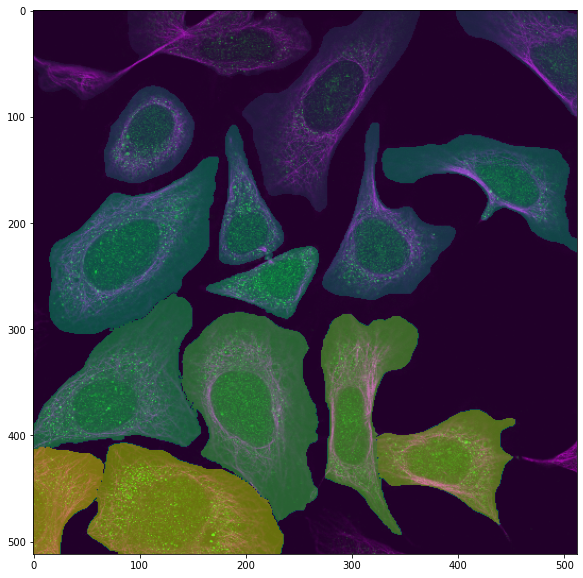

/workspace/Kaggle/HPA/hpa_2020/test/004a270d-34a2-4d60-bbe4-365fca868193_red.png
/workspace/Kaggle/HPA/hpa_2020/test/004a270d-34a2-4d60-bbe4-365fca868193_green.png
/workspace/Kaggle/HPA/hpa_2020/test/004a270d-34a2-4d60-bbe4-365fca868193_blue.png
/workspace/Kaggle/HPA/hpa_2020/test/004a270d-34a2-4d60-bbe4-365fca868193_yellow.png
(2048, 2048)


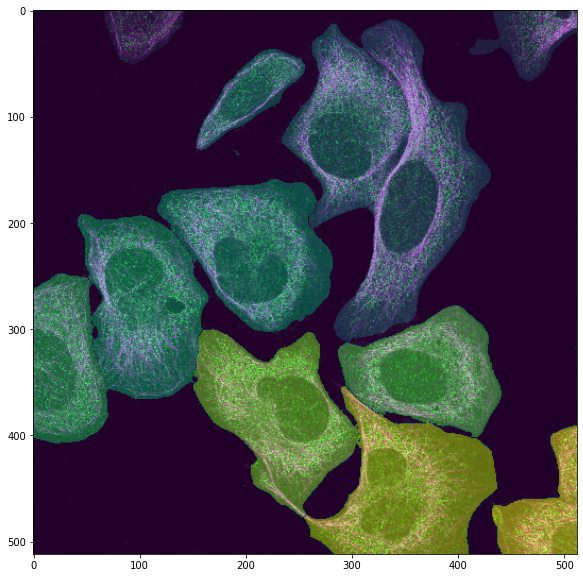

/workspace/Kaggle/HPA/hpa_2020/test/00537262-883c-4b37-a3a1-a4931b6faea5_red.png
/workspace/Kaggle/HPA/hpa_2020/test/00537262-883c-4b37-a3a1-a4931b6faea5_green.png
/workspace/Kaggle/HPA/hpa_2020/test/00537262-883c-4b37-a3a1-a4931b6faea5_blue.png
/workspace/Kaggle/HPA/hpa_2020/test/00537262-883c-4b37-a3a1-a4931b6faea5_yellow.png
(2048, 2048)


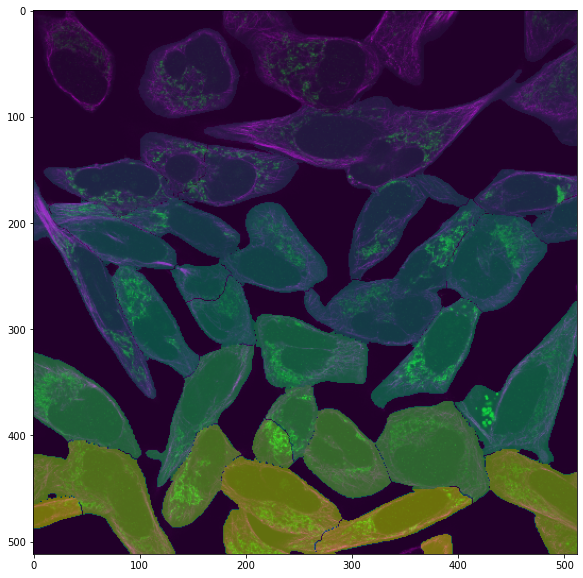

/workspace/Kaggle/HPA/hpa_2020/test/00c9a1c9-2f06-476f-8b0d-6d01032874a2_red.png
/workspace/Kaggle/HPA/hpa_2020/test/00c9a1c9-2f06-476f-8b0d-6d01032874a2_green.png
/workspace/Kaggle/HPA/hpa_2020/test/00c9a1c9-2f06-476f-8b0d-6d01032874a2_blue.png
/workspace/Kaggle/HPA/hpa_2020/test/00c9a1c9-2f06-476f-8b0d-6d01032874a2_yellow.png
(2048, 2048)


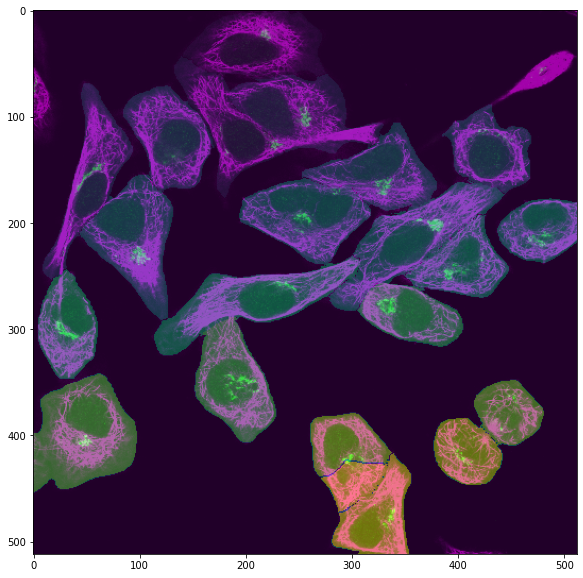

/workspace/Kaggle/HPA/hpa_2020/test/0173029a-161d-40ef-af28-2342915b22fb_red.png
/workspace/Kaggle/HPA/hpa_2020/test/0173029a-161d-40ef-af28-2342915b22fb_green.png
/workspace/Kaggle/HPA/hpa_2020/test/0173029a-161d-40ef-af28-2342915b22fb_blue.png
/workspace/Kaggle/HPA/hpa_2020/test/0173029a-161d-40ef-af28-2342915b22fb_yellow.png
(3072, 3072)


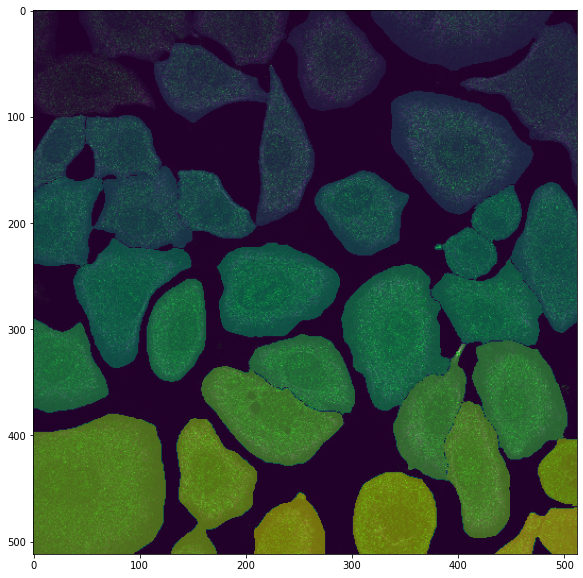

/workspace/Kaggle/HPA/hpa_2020/test/01a14326-67b8-43b0-ac7a-ba6dfb3c38ad_red.png
/workspace/Kaggle/HPA/hpa_2020/test/01a14326-67b8-43b0-ac7a-ba6dfb3c38ad_green.png
/workspace/Kaggle/HPA/hpa_2020/test/01a14326-67b8-43b0-ac7a-ba6dfb3c38ad_blue.png
/workspace/Kaggle/HPA/hpa_2020/test/01a14326-67b8-43b0-ac7a-ba6dfb3c38ad_yellow.png
(2048, 2048)


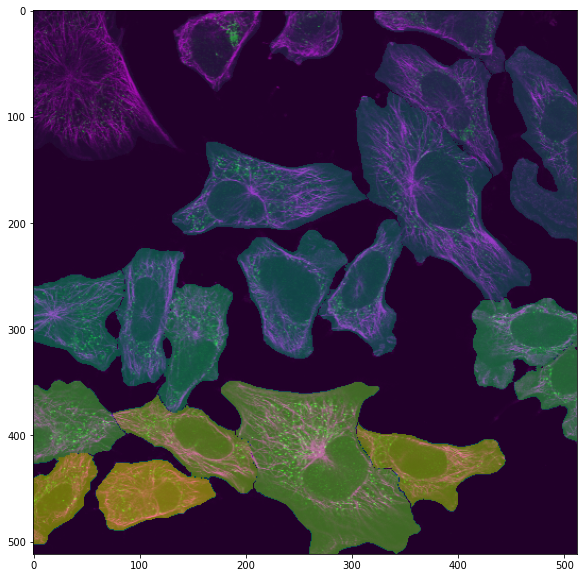

  0%|          | 0/94 [00:38<?, ?it/s]


In [46]:
all_cell_img_meta = {}
all_cell_masks = []
all_probs = []
processed_count = 0
for it, iter_data in tqdm(enumerate(test_loader, 0), total=len(test_loader)):
    images, masks, img_id_meta = iter_data
    for batch_i in range(0, len(masks), batch_size):
        batch_images = images[batch_i:batch_i + batch_size, ...]
        batch_masks = masks[batch_i:batch_i + batch_size]
        # print(batch_images.size(), len(batch_masks))

        batch_images = Variable(batch_images.cuda(), volatile=True)
        outputs = model(batch_images)
        logits = outputs

        probs = F.sigmoid(logits).data
        probs = probs.cpu().numpy().tolist()
        all_probs += probs

        processed_count += len(probs)

    all_cell_img_meta.update(img_id_meta)
    all_cell_masks.append(masks)

    if debug:
        break

all_cell_masks = np.concatenate(all_cell_masks, axis=0)
all_probs = np.array(all_probs).reshape(processed_count, -1)

In [47]:
# all_cell_img_meta, all_cell_masks.shape, all_probs.shape
len(all_cell_img_meta), all_cell_masks.shape, all_probs.shape

(6, (140, 512, 512), (140, 28))

In [48]:
all_predictions = []
for id in submit_df["ID"].values:
    if id in all_cell_img_meta:
        (start, end) = all_cell_img_meta[id]
        masks = all_cell_masks[start:end, ...]
        preds = all_probs[start:end, ...]
        # print(start, end, masks.shape, preds.shape)
        if masks.shape[0] > 0:
            new_preds = np.zeros((preds.shape[0], 19))
            for i in range(preds.shape[0]):
                for j in range(28):
                    new_class_i = old_class_mappings[j]
                    # Take maximum prob.
                    if preds[i, j] > new_preds[i, new_class_i]:
                        new_preds[i, new_class_i] = preds[i, j]
            print(new_preds.shape)

            # Generate RLE string for each cell mask
            # https://www.kaggle.com/dschettler8845/hpa-cellwise-classification-inference/notebook?scriptVersionId=55714434
            submit_strings = []
            for i in range(masks.shape[0]):
                preds = new_preds[i, ...]
                mask = masks[i, ...]
                rle_string = binary_mask_to_ascii(mask, mask_val=1)
                # print(rle_string)

                labels = sorted(
                    np.nonzero(preds > confidence_threshold)[0].tolist())
                # print(labels)
                for l in labels:
                    submit_strings.append(f"{l} {preds[l]:.6f} {rle_string}")

            if len(submit_strings) > 0:
                all_predictions.append(" ".join(submit_strings))
            else:
                all_predictions.append("")
        else:
            all_predictions.append("")

(15, 19)
(12, 19)
(36, 19)
(22, 19)
(34, 19)
(21, 19)


In [49]:
len(all_predictions)

6

In [50]:
# all_predictions

In [51]:
if debug:
    submit_df.iloc[:6, :]["PredictionString"] = all_predictions
else:
    submit_df["PredictionString"] = all_predictions
submit_df

,ID,ImageWidth,ImageHeight,PredictionString
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,16 0.556322 eNptT8sKAjEM/KU8WgQRvAiK3TSy4MWjRz...
1,004a270d-34a2-4d60-bbe4-365fca868193,2048,2048,16 0.537246 eNotkuuOmzAQhV8p9mC6kbraVlp1A3jGmH...
2,00537262-883c-4b37-a3a1-a4931b6faea5,2048,2048,14 0.602188 eNpdTLsKgDAM/KU8WlEUdHFQkwYcXAQRnJ...
3,00c9a1c9-2f06-476f-8b0d-6d01032874a2,2048,2048,18 0.643057 eNqtkDsPwjAMhP9SLunaVMmGAJsmQBkQEh...
4,0173029a-161d-40ef-af28-2342915b22fb,3072,3072,16 0.697824 eNplT8sKgDAM+6Vkgic96dUKig8ET4II4v...
5,01a14326-67b8-43b0-ac7a-ba6dfb3c38ad,2048,2048,14 0.590681 eNo1UG1vgkAM/kttQY14yZIh8WXQZmwDdU...
6,020a29cf-2c24-478b-8603-c22a90dc3e31,1728,1728,0 1 eNoLCAjJNgIABNkBkg==
7,02425037-3048-4ff3-9c0a-e9fc2d033e32,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
8,02531b54-078d-4a33-9c9c-0632b58c0a9a,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
9,025f04f1-6c68-4606-b34b-047738dd4804,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==


In [52]:
submit_df.to_csv("submission.csv", index=False)

In [ ]:
# for j, preds in enumerate(batch_preds):
#     for k in range(len(preds)):
#         if preds[k].size == 0:
#             batch_preds[j][k] = np.array([
#                 18,
#             ])
#             batch_confs[j][k] = np.array([
#                 1 - np.max(batch_o_preds[j][k]),
#             ])

In [ ]:
# test_loader = DataLoader(
#     test_dataset,
#     sampler=SequentialSampler(test_dataset),
#     batch_size=batch_size,
#     drop_last=False,
#     num_workers=0,
#     pin_memory=True,
#     collate_fn=collate_fn,
#     # collate_fn=lambda x: x,
# )

In [ ]:
# all_probs = []
# img_ids = test_loader.dataset.img_ids
# for it, iter_data in tqdm(enumerate(test_loader, 0), total=len(test_loader)):
#     images, masks, indices = iter_data
#     images = Variable(images.cuda(), volatile=True)
#     outputs = model(images)
#     logits = outputs

#     probs = F.sigmoid(logits).data
#     all_probs += probs.cpu().numpy().tolist()
# img_ids = img_ids[:len(all_probs)]
# all_probs = np.array(all_probs).reshape(len(img_ids), -1)

In [ ]:
# all_probs.shape

In [ ]:
# np.argmax(all_probs[0, :])
# 11

In [ ]:
def prob_to_result(probs, img_ids, th=0.5):
    predicted_probs = probs.copy()
    probs[np.arange(len(probs)), np.argmax(probs, axis=1)] = 1

    pred_list = []
    pred_list_new = []
    for line in probs:
        # Map old classes to new ones
        predicted_old_classes = sorted(
            list(set([i for i in np.nonzero(line > th)[0]])))
        predicted_new_classes = sorted(
            list(set([old_class_mappings[i]
                      for i in np.nonzero(line > th)[0]])))
        # print(predicted_classes)
        s = '|'.join([str(i) for i in predicted_old_classes])
        s_new = '|'.join([str(i) for i in predicted_new_classes])
        pred_list.append(s)
        pred_list_new.append(s_new)
    result_df = pd.DataFrame({
        # "ID": img_ids,
        "Predicted": pred_list,
        "Predicted_New": pred_list_new
    })
    return result_df

In [ ]:
result_df = prob_to_result(all_probs, None, th=confidence_threshold)
result_df.to_csv("result_comparison.csv", index=False)
result_df.head()

In [ ]:
# result_df["Predicted_New"].value_counts()

In [ ]:
# 0 	af650e14-9473-4691-b1aa-e1797607cd1f 	11 	8
# 1 	af650e14-9473-4691-b1aa-e1797607cd1f 	11 	8
# 2 	af650e14-9473-4691-b1aa-e1797607cd1f 	11 	8

In [ ]:
# reference_submit = pd.read_csv("/workspace/Kaggle/HPA/hpa-cellwise-classification-inference/submission.csv")
# print(reference_submit.shape)
# reference_submit

In [ ]:
# test_dataset.release_gpu()
# del model, test_dataset, test_loader
torch.cuda.empty_cache()
gc.collect()

In [ ]:
# def predict(test_loader, model, submit_out_dir, dataset):
#     all_probs = []
#     img_ids = np.array(test_loader.dataset.img_ids)
#     for it, iter_data in tqdm(enumerate(test_loader, 0),
#                               total=len(test_loader)):
#         images, indices = iter_data
#         images = Variable(images.cuda(), volatile=True)
#         outputs = model(images)
#         logits = outputs

#         probs = F.sigmoid(logits).data
#         all_probs += probs.cpu().numpy().tolist()
#     img_ids = img_ids[:len(all_probs)]
#     all_probs = np.array(all_probs).reshape(len(img_ids), -1)


# #     np.save(opj(submit_out_dir, 'prob_%s.npy' % dataset), all_probs)

# #     result_df = prob_to_result(all_probs, img_ids)
# #     result_df.to_csv(opj(submit_out_dir, 'results_%s.csv.gz' % dataset),
# #                      index=False,
# #                      compression='gzip')


# def prob_to_result(probs, img_ids, th=0.5):
#     probs = probs.copy()
#     probs[np.arange(len(probs)), np.argmax(probs, axis=1)] = 1

#     pred_list = []
#     for line in probs:
#         s = ' '.join(list([str(i) for i in np.nonzero(line > th)[0]]))
#         pred_list.append(s)
#     result_df = pd.DataFrame({ID: img_ids, PREDICTED: pred_list})
#     return result_df

In [ ]:
# # seeds = [args.seed
# #          ] if args.seeds is None else [int(i) for i in args.seeds.split(',')]
# seeds = list(range(4))
# for seed in seeds:
#     # test_dataset.random_crop = (seed != 0)
#     for augment in args.augment:
#         test_loader.dataset.transform = eval('augment_%s' % augment)
#         if args.crop_size > 0:
#             sub_submit_out_dir = opj(submit_out_dir,
#                                      '%s_seed%d' % (augment, seed))
#         else:
#             sub_submit_out_dir = opj(submit_out_dir, augment)
#         if not ope(sub_submit_out_dir):
#             os.makedirs(sub_submit_out_dir)
#         with torch.no_grad():
#             predict(test_loader, model, sub_submit_out_dir, dataset)

In [ ]:
# # Step 9: Post-Process
# batch_confs = [[pred[np.where(pred > CONF_THRESH)] for pred in o_preds]
#                for o_preds in batch_o_preds]
# batch_preds = [[np.where(pred > CONF_THRESH)[0] for pred in o_preds]
#                for o_preds in batch_o_preds]

# for j, preds in enumerate(batch_preds):
#     for k in range(len(preds)):
#         if preds[k].size == 0:
#             batch_preds[j][k] = np.array([
#                 18,
#             ])
#             batch_confs[j][k] = np.array([
#                 1 - np.max(batch_o_preds[j][k]),
#             ])

# # Step 10: Format Predictions To Create Prediction String Easily
# submission_rles = [
#     flatten_list_of_lists([[
#         m,
#     ] * len(p) for m, p in zip(masks, preds)])
#     for masks, preds in zip(submission_rles, batch_preds)
# ]
# batch_preds = [
#     flatten_list_of_lists(preds, to_string=True) for preds in batch_preds
# ]
# batch_confs = [[f"{conf:.4f}" for cell_confs in confs for conf in cell_confs]
#                for confs in batch_confs]

# # Step 11: Save Predictions to Be Added to Dataframe At The End
# predictions.extend([
#     " ".join(flatten_list_of_lists(zip(*[preds, confs, masks])))
#     for preds, confs, masks in zip(batch_preds, batch_confs, submission_rles)
# ])

In [ ]:
torch.cuda.empty_cache()
gc.collect()

### EOF